In [1]:
using Revise
import SSD

Precompiling SSD
  ✓ SSD
  1 dependency successfully precompiled in 16 seconds. 66 already precompiled.


In [327]:
using Clustering
using CPUTime
using CSV
using DataFrames
using Dates
using DelimitedFiles
using Distributions
using Distances
using Gurobi
using LinearAlgebra
using Plots
using Random

In [ ]:
using TimerOutputs

# Create a TimerOutput, this is the main type that keeps track of everything.
const to = TimerOutput()

In [ ]:
function get_res(file)
    extract = false
    instance = ""
    method = ""
    lb = -99
    ub = -99
    cpu_t = -99
    status = ""
    iter = -99
    mess = ""
    backup = ""
    i=1
    open(file,"r") do f  
        while !eof(f)
            line = readline(f)
            sline = split(line)
            if i == 7
                backup = line
            end
            if size(sline)[1] > 0
                if extract==true
                    if sline[1] == "Instance:"
                        instance = split(split(sline[2], "/")[end],".")[1]
                    elseif sline[1] == "Method:"
                        method = sline[2]
                    elseif sline[1] == "LB:"
                        lb = parse(Float64,sline[2])
                    elseif sline[1] == "UB:"
                        ub = parse(Float64,sline[2])
                    elseif sline[1] == "CPU_t:"
                        cpu_t = parse(Float64,sline[2])
                    elseif sline[1] == "Status:"
                        status = sline[2]
                    elseif sline[1] == "Iter:"
                        iter = parse(Float64,sline[2])
                    end
                end
                if sline[1] == "RESULTS"                
                    extract = true
                end
                if sline[1] == "slurmstepd:"
                    println(file)
                    mess = join(sline[end-2:end-1]," ")
                    if backup != ""
                        bk = split(backup,":")
                        instance = split(bk[2],",")[1]
                        method=bk[end]
                        println(bk)
                        println(instance)
                        println(method)
                    end
                    return instance, method, lb, ub, cpu_t, status, iter, mess
                end
            end
            i+=1
        end
    end
    return instance, method, lb, ub, cpu_t, status, iter, mess
end

In [ ]:
df_res1 = DataFrame(inst=String[], method=String[], lb=Float64[], ub=Float64[], cpu_t=Float64[],status=String[],iter=Float64[], error=String[])
directory = "results/"
files = readdir(directory)
for filename in files
# filename = "ssd_1218114_1.out"
    # println(filename)
    instance, method, lb, ub, cpu_t, status, iter, mess = get_res(directory*filename)
    push!(df_res1, (instance, method, lb, ub, cpu_t, status, iter, mess));
end

In [ ]:
sort!(df_res1,[:inst])

In [ ]:
CSV.write("results/results.csv",df_res1)

In [ ]:
function extract_pmed(file)
    open(file,"r") do f        
        line = readline(f)
        sline = split(line)
        nJ = parse(Int64,sline[2])
        nI = parse(Int64,sline[1]) - nJ
        Icoords = Matrix{Float64}(undef, 2, nI)
        Jcoords = Matrix{Float64}(undef, 2, nJ)
        i = 1
        do_J = true
        while !eof(f)
            line = readline(f)
            sline = split(line)
            if do_J
                Jcoords[1,i] = parse(Float64,sline[1])
                Jcoords[2,i] = parse(Float64,sline[2])
                if i == nJ
                    i = 0
                    do_J = false
                end
            else
                Icoords[1,i] = parse(Float64,sline[1])
                Icoords[2,i] = parse(Float64,sline[2])
            end
            i += 1
        end
        return nI, nJ, Icoords, Jcoords
    end    
end

In [ ]:
df = DataFrame(id=Int[], in_type=String[], nI=Int[], nJ=Int[], cv=Float64[], D=Int[], FLR=Float64[], FCR=Int[])

params0 = SSD.default_params()
data = SSD.default_data()

coords_bounds=(0,100)
r_bounds=(0.3, 0.4)
k=5
t=3
a_bounds=(80,120)

id = 1

in_type = "Own"
for (nI, nJ) in [(20,3), (50,10), (70,50)]
    for cv in [0.5, 1, 1.5]
        for D in [1, 10, 25, 50, 100]
            for FLR in [0.4, 0.6, 0.8]
                for FCR in [2,4,8,10]
                    push!(df, (id, in_type, nI, nJ, cv, D, FLR, FCR));
                    SSD.instance_gen(id, in_type, nI, nJ, coords_bounds, a_bounds, r_bounds, cv, D, k, t, FLR, FCR, params0)
                    id += 1
                end
            end
        end
    end
end

in_type = "p-med"
directory = "instances/p-median/"
                # (90,10)   (185,15)        (275,25)     (372,30)      (2338, 700)
for filename in ["SJC1.dat", "SJC2.dat", "SJC3a.dat", "SJC4a.dat"]#, "p3038_700.dat"]
    file = directory*filename
    nI, nJ, Icoords, Jcoords = extract_pmed(file)
    for cv in [0.5, 1, 1.5]
        for D in [1, 10, 25, 50, 100]
            for FLR in [0.4, 0.6, 0.8]
                for FCR in [2,4,8,10]
                    push!(df, (id, in_type, nI, nJ, cv, D, FLR, FCR));
                    SSD.instance_gen(id, in_type, nI, nJ, coords_bounds, a_bounds, r_bounds, cv, D, k, t, FLR, FCR, params0, Icoords, Jcoords)
                    id += 1
                end
            end
        end
    end
end

In [ ]:
CSV.write("instances/instances inventory.csv",df)

In [ ]:
# Create instances

df = DataFrame(id=Int[], in_type=String[], nI=Int[], nJ=Int[], cv=Float64[], D=Int[], FLR=Float64[], FCR=Int[])

params0 = SSD.default_params()
data = SSD.default_data()

coords_bounds=(0,100)
r_bounds=(0.3, 0.4)
k=5
# t=3
a_bounds=(50,320)

id = 28

in_type = "Own"
for (nI, nJ) in [(30,5), (200,30), (1000,115)] #[(20,3), (70,10), (250,10)]
    for t in [12]
        for cv in [1.5]
            for D in [5000, 40000, 150000]
                for FLR in [0.6]
                    for FCR in [8]
                        push!(df, (id, in_type, nI, nJ, cv, D, FLR, FCR));
                        SSD.instance_gen(id, in_type, nI, nJ, coords_bounds, a_bounds, r_bounds, cv, D, k, t, FLR, FCR, params0)
                        id += 1
                    end
                end
            end
        end
    end
end

In [ ]:
# Read the outputs for the relaxed tests

df_rel = DataFrame(id=Int[], size=String[], method=String[], 
    Relax_iters=Int64[], Relax_cuts=Int64[], OF=Float64[], CPU=Float64[], Memory=Float64[])
errors_rel=[]

directory = "../output_rel/"
filenames = []
for (root, dirs, files) in walkdir(directory)
    filenames = files
end

for filename in filenames
    
    file = directory*filename
    # file=directory*"ssd_1558214_10.out"
    # println("Processing $filename")
    
    open(file,"r") do f
        take_info = false
        row = []
        benders_sec = false
        method = ""
        
        while !eof(f)
            line = readline(f)
            sline_temp = split(line,":")
            if sline_temp[1]=="solving instance SSD id"
                inst_id = parse(Int64,split(sline_temp[2], ",")[1])
                method = sline_temp[end]
                push!(row, inst_id)
                push!(row, "S_M")
                push!(row, method)
            end

            if line == "RESULTS"
                take_info = true
            end
            # println("Line: $line")
            # println("Line length: $(length(line))")
            if take_info && length(line) > 0
                sline = split(line)
                data = sline[1]
                # println("$data is equal to Cap $(data=="Cap")")
                # println("Method is $method")
                if data == "LP"
                    push!(row, 0)
                    push!(row, 0)
                    text = sline[3]
                    push!(row, round(parse(Float64,text), digits=2))
                elseif data == "Rel" && sline[2]== "iters:"
                    text = replace(sline[3], "Any"=>"", "["=>"", "]"=>"", ","=>"") 
                    push!(row, parse(Int64,text))
                elseif data == "Rel" && sline[2]== "cuts:"
                    text = replace(sline[3], "Any"=>"", "["=>"", "]"=>"", ","=>"") 
                    push!(row, parse(Int64,text))
                elseif data == "Rel" && sline[2]== "lb:"
                    text = replace(sline[3], "Any"=>"", "["=>"", "]"=>"", ","=>"") 
                    push!(row, round(parse(Float64,text), digits=2))
                elseif data == "CPU_t:"
                    text = sline[2]
                    push!(row, parse(Float64,text))
                elseif data == "Memory:"
                    text =sline[2]
                    push!(row, parse(Float64,text))
                end
            end
        end
        # println(row)
        try
            push!(df_rel, row)
        catch
            push!(errors_rel, parse(Int64,split(split(filename,"_")[end],".")[begin]))
        end
    end
    # break
end

In [ ]:
# Export the data frame
sort!(df_rel, [:id, :size], rev=[false, true])
file_name = "111024_results_relaxations.csv"

CSV.write(file_name, df_rel)

In [ ]:
df_rel

In [ ]:
sort(errors_rel)

In [ ]:
# Read the outputs

df = DataFrame(id=Int[], size=String[], method=String[], OF=Float64[], LC=Float64[], AL=Float64[], 
    CC=Float64[], y=Array[], nVars=Int64[], nCons=Array[], Nodes=Int64[], Feas_cuts=Int64[], Opt_cuts=Int64[], 
    Relax_iters=Array[], Relax_cuts=Array[], Relax_bounds=Array[],
    test_cap=String[], test_1cap=String[], test_1dem=String[], CPU=Float64[], Memory=Float64[], Status=String[], Iter=Int64[])
# df = DataFrame(id=Int[], inst_type =String[], method=String[], OF=Float64[], LC=Float64[], AL=Float64[], 
#     CC=Float64[], y=Array[], Nodes=Int64[], Feas_cuts=Int64[], Opt_cuts=Int64[], Relax_cuts=Array[],
#     test_cap=String[], test_1cap=String[], test_1dem=String[], CPU=Float64[], Memory=Float64[])
errors=[]

directory = "../output/"
filenames = []
for (root, dirs, files) in walkdir("../output/")
    filenames = files
end

for filename in filenames
    
    file = directory*filename
    # file=directory*"ssd_1558214_10.out"
    # println("Processing $filename")
    
    open(file,"r") do f
        take_info = false
        row = []
        method=""
        benders_sec = false
        rel_lb_temp = 0
        rel_ub_temp = 0
        while !eof(f)
            line = readline(f)
            sline_temp = split(line,"=")
            if sline_temp[1]=="With the agg Any[\"K\"] the bounds are lb"
                rel_lb_temp = parse(Float64,split(sline_temp[2])[1])
                rel_ub_temp = parse(Float64,sline_temp[end])
            end

            if line == "RESULTS"
                take_info = true
            end
            # println("Line: $line")
            # println("Line length: $(length(line))")
            if take_info && length(line) > 0
                sline = split(line)
                data = sline[1]
                # println("$data is equal to Cap $(data=="Cap")")
                if data == "Instance:"
                    text = sline[2]
                    push!(row, parse(Int64,split(split(text,"/")[end],".")[begin]))
                    inst_type = "S_M"
                    if split(filename,"_")[2] == "large"
                        inst_type = "L"
                    end
                    push!(row, inst_type)
                elseif data == "Method:"
                    method = sline[2]
                    push!(row, method)
                elseif data == "OF:"
                    text = sline[2]
                    push!(row, parse(Float64,text))
                elseif data == "Location"
                    text = sline[3]
                    push!(row, parse(Float64,text))
                elseif data == "Allocation"
                    text = sline[3]
                    push!(row, parse(Float64,text))
                elseif data == "Congestion"
                    text = sline[3]
                    push!(row, parse(Float64,text))
                elseif string(data[1])=="y"
                    push!(row, [parse(Int64,sline[i][end-1]) for i in 1:length(sline)])
                    benders_sec = true
                    if method == "lazy_cuts"
                        push!(row, 0)
                        push!(row, [0])
                        push!(row, 0)
                        push!(row, 0)
                        push!(row, 0)
                        push!(row, [0])
                        push!(row, [0])
                        push!(row, [0,0])
                        benders_sec = false
                    end
                elseif benders_sec
                    if data == "Vars:"
                        text = sline[2]
                        push!(row, parse(Int64,text))
                    elseif data == "Cons:"
                        sline_num = [replace(sline[i],"Any"=>"", "["=>"", "]"=>"", ","=>"") for i in 2:length(sline)]
                        push!(row, [parse(Int64,sline_num[i]) for i in 1:length(sline_num)])
                        # push!(row, parse(Int64,text))
                    elseif data == "nodes:"
                        text = sline[2]
                        push!(row, parse(Int64,text))
                    elseif data == "Feas"
                        text = sline[3]
                        push!(row, parse(Int64,text))
                    elseif data == "Opt"
                        text = sline[3]
                        push!(row, parse(Int64,text))
                    elseif data == "Rel"
                        sline_num = [replace(sline[i],"Any"=>"", "["=>"", "]"=>"", ","=>"") for i in 3:length(sline)]
                        push!(row, [parse(Int64,sline_num[i]) for i in 1:length(sline_num)])
                        # if sline[2] == "iters"
                        #     push!(row, [parse(Int64,sline_num[i]) for i in 1:length(sline_num)])
                        # elseif sline[2] == "cuts"
                        #     text = sline[3]
                        #     push!(row, [parse(Int64,sline[i][end-1]) for i in 3:length(sline)])
                        # end
                        if sline[2] == "cuts:"
                            push!(row, [rel_lb_temp,rel_ub_temp])
                            benders_sec = false
                        end
                    end
                    # end
                elseif data=="Cap"  
                    text = sline[3]                    
                    push!(row, text)
                elseif data == "1_cap:"
                    text = sline[2]
                    push!(row, text)
                elseif data == "1_demand:"
                    text = sline[2]
                    push!(row, text)
                elseif data == "CPU_t:"
                    text = sline[2]
                    push!(row, parse(Float64,text))
                elseif data == "Memory:"
                    text =sline[2]
                    push!(row, parse(Float64,text))
                elseif data == "Status:"
                    text =sline[2]
                    push!(row, text)
                elseif data == "Iter:"
                    text =sline[2]
                    push!(row, parse(Int64,text))
                end
            end
        end
        # println(row)
        try
            push!(df, row)
        catch
            push!(errors, parse(Int64,split(split(filename,"_")[end],".")[begin]))
        end
    end
    # break
end

In [ ]:
# Export the data frame
sort!(df, [:id, :size, :method], rev=[false, true, true])
file_name = "111024_results_v2.csv"

CSV.write(file_name, df)

In [ ]:
df

In [ ]:
sort(errors)

In [ ]:
sort!(df, [:id, :size, :method], rev=[false, true, true])
filter(row -> row.size == "S_M", df)

In [ ]:
errors

# Clustering

In [329]:
directory = "instances/Own/"
filename= "7.txt" #"1.txt" # "25.txt" # "6.txt"#"18_3.txt"

"7.txt"

In [330]:
# Create default parameters
params = SSD.default_params()
# Create the data container
data = SSD.default_data()
# Read the instance
SSD.read_file(directory*filename, data)


instance file instances/Own/7.txt parsed successfully



In [326]:
data.Jcoords

2×5 Matrix{Float64}:
 87.918    1.7353  88.39    68.3051  20.445
 79.6214  44.296   75.7879  85.1014  72.3902

In [332]:
floor(data.J/10)

11.0

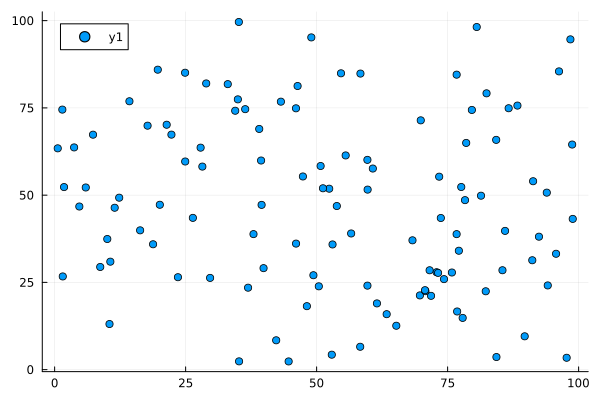

In [336]:
x=data.Jcoords[1,:]
y=data.Jcoords[2,:]
scatter(x,y)

In [350]:
for clus in 1:nclusters(R)
    fac = findall(==(clus),assignments(R))
    x=data.Jcoords[1,fac]
    y=data.Jcoords[2,fac]
    if clus == 1
        scatter(x,y)
    else
        scatter!(x,y)
    end
end

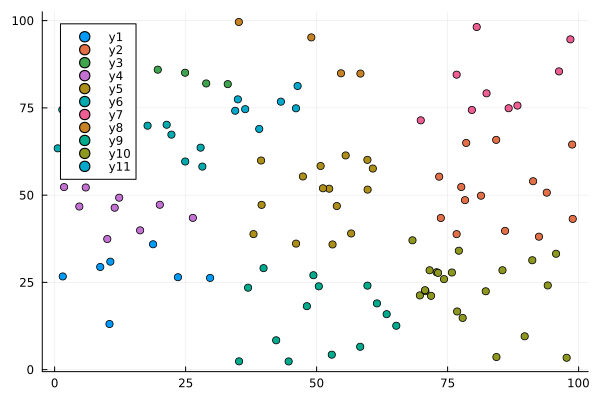

In [363]:
clus=11
fac = findall(==(clus),assignments(R))
x=data.Jcoords[1,fac]
y=data.Jcoords[2,fac]
scatter!(x,y)

In [386]:
n_clus = Int64(floor(data.J/10))
res_clus = kmeans(data.Jcoords, n_clus) 
@assert nclusters(res_clus) == n_clus

In [387]:
nclusters(res_clus), n_clus, counts(res_clus)

(11, 11, [17, 9, 7, 15, 5, 8, 9, 14, 15, 11, 5])

In [399]:
a=[[1,1,1], [2,2]]
b=[[1,1,1], [2,2]]
c=[[2,2], [1,1,1]]

┌ Error: Failed to revise C:\Users\m_hoyo\OneDrive - Concordia University - Canada\PhD\Thesis\service system design\GitHub\SSD.jl\src\benders.jl
│   exception =
│    ParseError:
│    # Error @ ]8;;file://C:/Users/m_hoyo/OneDrive - Concordia University - Canada/PhD/Thesis/service system design/GitHub/SSD.jl/src/benders.jl#1466:4\C:\Users\m_hoyo\OneDrive - Concordia University - Canada\PhD\Thesis\service system design\GitHub\SSD.jl\src\benders.jl:1466:4]8;;\
│        end
│    end
│    #  └ ── Expected `end`
│    Stacktrace:
│     [1] top-level scope
│       @ none:1
└ @ Revise C:\Users\m_hoyo\.julia\packages\Revise\bAgL0\src\packagedef.jl:724
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   C:\Users\m_hoyo\OneDrive - Concordia University - Canada\PhD\Thesis\service system design\GitHub\SSD.jl\src\benders.jl
│ 
│ If the error was due to evaluation order, it can sometimes be resolved by calling `Revise.retry()`.
│ Use Revise.errors() to repor

2-element Vector{Vector{Int64}}:
 [2, 2]
 [1, 1, 1]

In [401]:
a==b
a==c

false

In [392]:
R = []
K = 1:data.k
for clus in 1:nclusters(res_clus)
    Rl=[]
    fac = findall(==(clus),assignments(res_clus))
    for f in fac
        for k in K
            push!(Rl, (f,k))
        end
    end
    push!(R, Rl)
end

In [397]:
z=[1 2 3; 4 5 6; 7 8 9]
a=[(1,1), (2,2), (3,2)]
sum(z[j,k] for (j,k) in a)
    

14

In [398]:
z

3×3 Matrix{Int64}:
 1  2  3
 4  5  6
 7  8  9

# Solve 1 inst

In [429]:
directory = "instances/Own/"
filename= "6.txt" #"1.txt" # "25.txt" # "6.txt"#"18_3.txt"

"6.txt"

In [ ]:
solve_method = "bendersFC"  #"nlp"#"heur_LS"#"iter_cuts"#"lazy_cuts"#"bendersWS"#"heur_NM"#"heur_FB" "heur_NM" - bendersPK
println("Starting $solve_method")

el = @CPUelapsed res = SSD.solve_ssd(directory*filename, [solve_method])
# el = @CPUelapsed res = SSD.solve_ssd(directory*filename, [""])

Starting bendersFC

instance file instances/Own/6.txt parsed successfully

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-18
Set parameter Cuts to value 0
Set parameter MIPGap to value 1e-05
Set parameter MIPFocus to value 3
Set parameter LazyConstraints to value 1
Set parameter Threads to value 1
Set parameter TimeLimit to value 10800.997
Set parameter Cuts to value 0
Set parameter MIPGap to value 1e-05
Set parameter Threads to value 1
Set parameter TimeLimit to value 10792.653
Set parameter Cuts to value 0
Set parameter MIPGap to value 1e-05
Set parameter Threads to value 1
Set parameter TimeLimit to value 10792.574
Set parameter Cuts to value 0
Set parameter MIPGap to value 1e-05
Set parameter Threads to value 1
Set parameter TimeLimit to value 10792.497
Set parameter Cuts to value 0
Set parameter MIPGap to value 1e-05
Set parameter Threads to value 1
Set parameter TimeLimit to value 10792.211
Set parameter Cuts to value 0
Set parameter MIPGa

In [ ]:
With this agg the bounds are lb=36742.306585716186 and ub=45175.91340962884 after 1620 cuts
With this agg the bounds are lb=36963.075250220514 and ub=43261.18531459048 after 540 cuts
With this agg the bounds are lb=39215.37055801917 and ub=39255.0420658668 after 3778 cuts
With this agg the bounds are lb=39234.80163098489 and ub=39237.623592385295 after 197 cuts
With this agg the bounds are lb=39235.2594481431 and ub=39236.0868382756 after 7 cuts

In [412]:
if solve_method == "iter_cuts"
    println("$solve_method: lb=$(res[1]), ub=$(res[2]),
        of_term1_lb=$(res[3]), of_term2_lb=$(res[4]), of_term3_lb=$(res[5]),
        of_term1_ub=$(res[6]), of_term2_ub=$(res[7]), of_term3_ub=$(res[8]),
        y=$(res[9]), CPU_t=$el")

    #of (1), Fterm, Allocterm, Congterm, y (5), x, status, lb, ub, relax_iters (10), cuts_iters, n_vars, n_cons, n_nodes, tests_feas (15)
elseif solve_method in ["benders", "bendersWS1", "bendersWS2", "bendersMW", "bendersPK", "bendersSH", "bendersFC", "bendersIter","bendersIterPK"]
    println("$solve_method: of=$(res[1]), of_term1=$(res[2]), of_term2=$(res[3]), of_term3=$(res[4]), y=$(res[5]), CPU_t=$el, nodes=$(res[14]),
        feas=$(res[7].nFeasCuts), opt=$(res[7].nOptCuts)") 
else
    println("$solve_method: of=$(res[1]), of_term1=$(res[2]), of_term2=$(res[3]), of_term3=$(res[4]), y=$(res[5]), CPU_t=$el")
end

Cluster: of=6441.0235, of_term1=1331.8413, of_term2=4228.0059, of_term3=881.1763, y=Any[0, 5, 4, 0, 5], CPU_t=9.858


In [ ]:
#1
lazy_cuts: of=2759.952, of_term1=720.4022, of_term2=1459.0483, of_term3=580.5014, y=Any[5, 4, 5, 0, 0], CPU_t=1.297
benders: of=2759.952, of_term1=720.4022, of_term2=1459.0483, of_term3=580.5014, y=Any[5, 4, 5, 0, 0], CPU_t=4.063, nodes=1441,
        feas=1, opt=668
bendersSH: of=2759.858, of_term1=720.4022, of_term2=1459.0246, of_term3=580.4312, y=Any[5, 4, 5, 0, 0], CPU_t=2.578, nodes=1227,
        feas=0, opt=617
bendersMW: of=2759.952, of_term1=720.4022, of_term2=1459.0483, of_term3=580.5014, y=Any[5, 4, 5, 0, 0], CPU_t=4.64, nodes=1378,
        feas=1, opt=1262
bendersPK: of=2759.952, of_term1=720.4022, of_term2=1459.0483, of_term3=580.5014, y=Any[5, 4, 5, 0, 0], CPU_t=4.391, nodes=1378,
        feas=1, opt=1292
bendersFC: of=2759.952, of_term1=720.4022, of_term2=1459.0483, of_term3=580.5014, y=Any[5, 4, 5, 0, 0], CPU_t=5.609, nodes=1429,
        feas=1, opt=743

In [ ]:
#2
lazy_cuts: of=6441.0235, of_term1=1331.8413, of_term2=4228.0059, of_term3=881.1763, y=Any[0, 5, 4, 0, 5], CPU_t=2.704
benders: of=6441.0235, of_term1=1331.8413, of_term2=4228.0059, of_term3=881.1763, y=Any[0, 5, 4, 0, 5], CPU_t=6.796, nodes=1342,
        feas=1, opt=1726
bendersSH: of=6440.893, of_term1=1331.8413, of_term2=4227.9541, of_term3=881.0976, y=Any[0, 5, 4, 0, 5], CPU_t=6.422, nodes=1315,
        feas=0, opt=1585
bendersMW: of=6441.0235, of_term1=1331.8413, of_term2=4228.0059, of_term3=881.1763, y=Any[0, 5, 4, 0, 5], CPU_t=10.36, nodes=1374,
        feas=1, opt=3688
bendersPK: of=6441.0235, of_term1=1331.8413, of_term2=4228.0059, of_term3=881.1763, y=Any[0, 5, 4, 0, 5], CPU_t=10.375, nodes=1374,
        feas=1, opt=3795
bendersFC: of=6441.0235, of_term1=1331.8413, of_term2=4228.0059, of_term3=881.1763, y=Any[0, 5, 4, 0, 5], CPU_t=11.047, nodes=1330,
        feas=1, opt=1776

## Is the solution correct?

In [ ]:
data0.I, data0.J, data0.k, data0.t

In [ ]:
# Allocation decisions
x = res[7]
# Location decisions
y = SSD.gen_y(data0, res[6]);

### Is feasible?

In [ ]:
# See if the demand can be allocated with the given capacity

In [ ]:
# Facility capacity constraint
# For each time period, see the allocation of customers
for t in 1:data0.t
    sum(round.(x[:,:,t]'data0.a[:,t], digits=3) .> sum(y.*data0.Q,dims=2)) > 0 ? println("Bad for t=$t") : println("Ok for t=$t")
end

In [ ]:
# All the demand is assigned
for t in 1:data0.t
    for i in 1:data0.I
        sum(x[i,j,t] for j in 1:data0.J) == 1 ? print("") : println("Bad for node $i in t=$t") #println("Ok for node $i in t=$t")
    end
end

In [ ]:
# Only one cap level selected
for j in 1:data0.J
    sum(y[j,k] for k in 1:data0.k) == 1 ? print("") : sum(y[j,k] for k in 1:data0.k) == 0 ? print("") : println("Bad for facility $j")
end

# Plot de bounds

In [ ]:
#of (1), Fterm, Allocterm, Congterm, y (5), x, status, lb, ub, relax_iters (10), cuts_iters, n_vars, n_cons, n_nodes, tests_feas (15)
ordered_lb = sort(res[8])
ordered_ub = sort(res[9])

of_val = 7689.0801

# LB
plot(0:res[7].nIter, collect(values(ordered_lb)), label="lb",
    size=(1000,400), markershape=:xcross, legend=:topleft)

# UB
plot!(0:res[7].nIter, collect(values(ordered_ub)), label="ub",
    size=(1000,400), markershape=:xcross, color=:red)

# LP relaxation optimal
# plot!(1:status.nIter, zeros(status.nIter).+of_val_rel, label="lp relax optimal", color=:orange, linestyle = :dash)
# Optimal
plot!(1:res[7].nIter, zeros(res[7].nIter).+of_val, label="optimal", color=:red, linestyle = :dash)

ylims!(0, of_val*1.5)

In [ ]:
# Instance Own/18_3 with bendersIter
ordered_lb = sort(res[12])
ordered_ub = sort(res[13])

# of_val = 7555.2078
# of_val_rel = 5951.6929
# gaps = [10e-3, 5e-2, 10e-2]
# refs = [of_val*(1-i) for i in gaps]
plot(1:status.nIter, collect(values(ordered_lb))[2:end])#, label="lb")#,
    # size=(1000,400), markershape=:xcross, legend=:topleft)

# LP relaxation optimal
# plot!(1:status.nIter, zeros(status.nIter).+of_val_rel, label="lp relax optimal", color=:orange, linestyle = :dash)
# Optimal
# plot!(1:status.nIter, zeros(status.nIter).+of_val, label="optimal", color=:red, linestyle = :dash)
# Gaps
# for i in 1:length(gaps)
#     gap = gaps[i]
#     plot!(1:status.nIter, zeros(status.nIter).+refs[i], label=gap, linestyle = :dash)
# end
# plot!([res[end-1]+1,res[end-1]+1],[collect(values(ordered_lb))[1],of_val], label="start branching", color=:black)

# title!("I = 250, J = 10 with $solve_method - Papadakos (3h - time lim)")

# xlims!(0, 100)

In [ ]:
ordered_lb = sort(res[end-1])
ordered_ub = sort(res[end]);
# Instance Own/18_3 with benders_cb
of_val = 7555.2078
of_val_rel = 5070.6749
gaps = [10e-3, 5e-2, 10e-2, round(abs(of_val-last(collect(values(ordered_ub)))/of_val),digits=2)]
refs = [of_val*(1-i) for i in gaps]
plot(1:status.nIter, collect(values(ordered_ub)), label="ub",
    size=(1000,400), markershape=:xcross, legend=:topleft)

# LP relaxation optimal
plot!(1:status.nIter, zeros(status.nIter).+of_val_rel, label="lp relax optimal", color=:orange, linestyle = :dash)
# Optimal
plot!(1:status.nIter, zeros(status.nIter).+of_val, label="optimal", color=:red, linestyle = :dash)
# Gaps
# for i in 1:length(gaps)
#     gap = gaps[i]
#     plot!(1:status.nIter, zeros(status.nIter).+refs[i], label=gap, linestyle = :dash)
# end
# plot!([res[end-1]+1,res[end-1]+1],[collect(values(ordered_lb))[1],of_val], label="start branching", color=:black)

title!("I = 250, J = 10 with $solve_method - Papadakos (163 s)")

xlims!(0, 100)

In [ ]:
# Instance Own/6
of_val = 1914.4834
gaps = [10e-3, 5e-2, 10e-2, round(abs(of_val-ordered_lb[res[end-1]])/of_val,digits=2)]
refs = [of_val*(1-i) for i in gaps]
plot(1:status.nIter, collect(values(ordered_lb)), label="lb",
    size=(1000,400), markershape=:xcross)
plot!(1:status.nIter, collect(values(ordered_ub)), label="ub", markershape=:xcross)
# ylims!(1500, 4000)
# Optimal
plot!(1:status.nIter, zeros(status.nIter).+of_val, label="optimal", color=:red, linestyle = :dash, lw=1)
# Gaps
for i in 1:length(gaps)
    gap = gaps[i]
    plot!(1:status.nIter, zeros(status.nIter).+refs[i], label=gap, linestyle = :dash, lw=1)
    annotate!(status.nIter, refs[i], text("$gap", :left, 12, :black))
end
plot!([res[end-1]+1,res[end-1]+1],[collect(values(ordered_lb))[1],of_val], label="start branching", color=:black)

title!("I = 20, J = 3")